# Optimización de Parámetros - ARIMA (uno)

In [2]:
## Get current work directory to load all the custom modules
from pathlib import Path
import sys
BASE_DIR = Path().absolute().resolve(strict=True).parent.parent.parent
if str(BASE_DIR) not in sys.path:
    sys.path.append(str(BASE_DIR))

In [3]:
DATA_PATH = os.path.join(BASE_DIR, 'data', 'autos')
print(DATA_PATH)

/workspace/Externos/TimeSeries/BenchMark/data/autos


In [4]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer

In [5]:
import statsmodels.api as sm
# from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import r2_score
from matplotlib import pyplot as plt
import optuna
import datetime

In [6]:

from helpers.general import  print_forecasting_results
from sklearn.model_selection import cross_val_score
from modulos.arima.gruas.general import format_timeseries, show_results_r2, arima_forecasting, total_forecasting, show_optimizer_results

In [7]:
data = pd.read_csv(os.path.join(DATA_PATH, 'producto.csv'), parse_dates=['Periodo'])
data.head()

,Periodo,idArticulo,ventas,DescProducto
0,2021-05-01,9950,37.0,REFRIGERANTE COOLANT AZUL/NATURAL TRANSP. GALO...
1,2021-04-01,9950,19.0,REFRIGERANTE COOLANT AZUL/NATURAL TRANSP. GALO...
2,2021-03-01,9950,9.0,REFRIGERANTE COOLANT AZUL/NATURAL TRANSP. GALO...
3,2021-02-01,9950,8.0,REFRIGERANTE COOLANT AZUL/NATURAL TRANSP. GALO...
4,2021-01-01,9950,76.0,REFRIGERANTE COOLANT AZUL/NATURAL TRANSP. GALO...


In [8]:
data['Periodo'][0]

Timestamp('2021-05-01 00:00:00')

In [9]:
# Pivotando las tablas y llenando de ceros las ventas que no existen.
df_time = format_timeseries(data)
df_time.tail()

idArticulo,551,594,1208,1224,1627,3745,3882,3883,4070,4827,...,20301,20305,20309,20310,20697,20769,21577,23900,26158,26170
Periodo,,,,,,,,,,,,,,,,,,,,,
2021-01-01,6.0,3.0,170.0,2.0,10.0,6.0,3.0,4.0,7.0,18.0,...,8.0,4.0,1.0,2.0,0.0,5.0,7.0,260.0,16.0,5.0
2021-02-01,4.0,4.0,220.0,0.0,17.0,11.0,3.0,3.0,5.0,16.0,...,4.0,1.0,1.0,11.0,2.0,1.0,11.0,16.0,5.0,18.0
2021-03-01,4.0,6.0,155.0,0.0,8.0,10.0,2.0,0.0,4.0,2.0,...,14.0,11.0,11.0,9.0,2.0,12.0,13.0,80.0,6.0,14.0
2021-04-01,8.0,8.0,155.0,6.0,25.0,24.0,3.0,9.0,0.0,1.0,...,11.0,4.0,1.0,3.0,1.0,3.0,0.0,71.0,10.0,5.0
2021-05-01,13.0,4.0,80.0,1.0,5.0,4.0,0.0,4.0,0.0,1.0,...,15.0,9.0,9.0,4.0,1.0,1.0,16.0,41.0,3.0,0.0


## Optimizando un solo Producto

## Baseline ARIMA

In [10]:
df_time.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 41 entries, 2018-01-01 to 2021-05-01
Data columns (total 49 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   551     41 non-null     float64
 1   594     41 non-null     float64
 2   1208    41 non-null     float64
 3   1224    41 non-null     float64
 4   1627    41 non-null     float64
 5   3745    41 non-null     float64
 6   3882    41 non-null     float64
 7   3883    41 non-null     float64
 8   4070    41 non-null     float64
 9   4827    41 non-null     float64
 10  5389    41 non-null     float64
 11  5579    41 non-null     float64
 12  6833    41 non-null     float64
 13  7798    41 non-null     float64
 14  7799    41 non-null     float64
 15  7801    41 non-null     float64
 16  9776    41 non-null     float64
 17  9950    41 non-null     float64
 18  10702   41 non-null     float64
 19  10927   41 non-null     float64
 20  10960   41 non-null     float64
 21  10964   41 non-null  

In [11]:
from sklearn.base import BaseEstimator, RegressorMixin
import statsmodels.api as sm
class SMWrapper(BaseEstimator, RegressorMixin):
    """ A universal sklearn-style wrapper for statsmodels regressors """
    def __init__(self, model_class, fit_intercept=True):
        self.model_class = model_class
        self.fit_intercept = fit_intercept
    def fit(self, X, y):
        if self.fit_intercept:
            X = sm.add_constant(X)
        self.model_ = self.model_class(y, X)
        self.results_ = self.model_.fit()
        return self
    def predict(self, X):
        if self.fit_intercept:
            X = sm.add_constant(X)
        return self.results_.predict(X)

In [14]:
   
idArticulo = 4827

result = total_forecasting(df_time[[idArticulo]])
def arima_forecasting(data, ar=2, ii=1, ma=2):
    """
    Forecasting using ARIMA model, 
    return model.fit()
    """
    df = data.copy()
    df.index = pd.DatetimeIndex(df.index).to_period('M')
    model = ARIMA(df, order=(ar, ii, ma))
    results = model.fit()
    return results

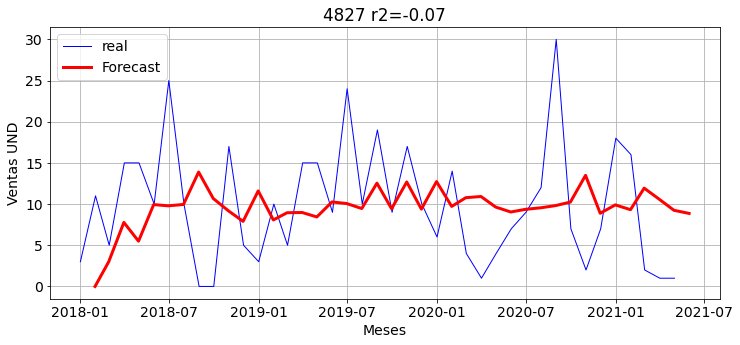

-0.06961975057475489

In [15]:
    
show_results_r2(df_time, result, idArticulo)

# Optimización por [OPTUNA](https://github.com/optuna/optuna/blob/40b097650d312913989b5825aa9c9adf4b15c396/docs/source/index.rst)

In [16]:
# You can increase iteration number.
iteration = 200

optuna.logging.disable_default_handler() # not display log
#optuna.logging.enable_default_handler() # display log

In [18]:

%%time

def objective(trial):
    r_min = 0
    r_max = 6
    ar = trial.suggest_int('ar', r_min, r_max)
    ii = trial.suggest_int('ii', r_min, r_max)
    ma = trial.suggest_int('ma', r_min, r_max)
    idArticulo = 4827
    pred = total_forecasting(df_time[[idArticulo]], ar, ii, ma)
    score = r2_score(df_time[idArticulo], pred.apply(lambda x: round(x,0)) )
    return score
SEED=5050

#study = optuna.create_study(direction='maximize')
study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=SEED))
study.optimize(objective, n_trials=iteration)

/home/dave-linux/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/dave-linux/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/dave-linux/.local/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/dave-linux/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/dave-linux/.local/lib/python3.8

CPU times: user 11min 25s, sys: 10min 38s, total: 22min 3s
Wall time: 3min 52s


/home/dave-linux/.local/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [22]:
study.best_value

0.3702579843944044

In [23]:
study.best_params

{'ar': 6, 'ii': 0, 'ma': 6}

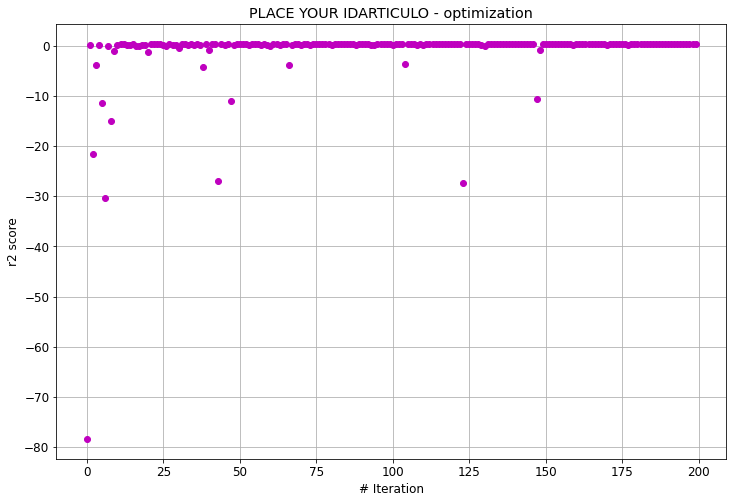

In [24]:
show_optimizer_results([trial.value for trial in study.trials])

In [19]:
idArticulo = 4827
# {'ar': 7, 'ii': 1, 'ma': 10} 
result = arima_forecasting(df_time[[idArticulo]],  **study.best_params)

/home/dave-linux/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/dave-linux/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/dave-linux/.local/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


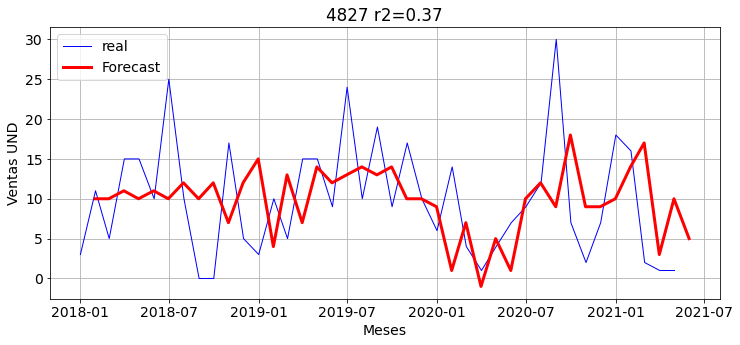

In [20]:
r2 = show_results_r2(df_time, result.fittedvalues. apply(lambda x: round(x,0)), idArticulo)

In [25]:
results = pd.DataFrame()
row = {'idArticulo':idArticulo, 'hyper':study.best_params, 'r2':r2 , 'model': 'ARIMA'}
results = results.append(row, ignore_index=True)
results.head()
results.to_csv(os.path.join(DATA_PATH, 'result', 'arima', 'arima_one.csv'), index=False)